In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, Optional

In [3]:
def config_domain(NX, NY, W, H, AXI=0):
    global NI, NJ, IDIM, JDIM, IJDIM, NIM, NJM, DX0, DY0, IR
    IR = AXI

    NI = NX
    NJ = NY
    IDIM = NI + 10
    JDIM = NJ + 10
    IJDIM = max(IDIM, JDIM)
    NIM = NI - 1
    NJM = NJ - 1

    DX0 = W / (NI - 1)
    DY0 = H / (NJ - 1)

def init_domain():
    global IDIM, JDIM, IJDIM
    global NI, NIM, NJ, NJM
    global XP, XU, YP, YV
    global DX0, DY0
    global DXP, DXU, DYP, DYV
    global RP, RU

    # DOMAIN ARRAYS
    XP = np.zeros(IDIM)
    XU = np.zeros(IDIM)

    # CONTROL VOLUME SIZE ARRAYS
    DXP = np.zeros(IDIM)
    DXU = np.zeros(IDIM)
    YP = np.zeros(JDIM)
    YV = np.zeros(JDIM)
    DYP = np.zeros(JDIM)
    DYV = np.zeros(JDIM)
    RP = np.zeros(IDIM)
    RU = np.zeros(IDIM)

    # initialize domain sizes
    for i in range(1, NI + 1):
        XU[i] = DX0 * (i - 1)

    for i in range(1, NI):
        XP[i] = (XU[i] + XU[i + 1]) / 2

    for j in range(1, NJ + 1):
        YV[j] = DY0 * (j - 1)

    for j in range(1, NJ):
        YP[j] = (YV[j] + YV[j + 1]) / 2

    XP[0] = XU[1]
    XP[NI] = XU[NI]
    YP[0] = YV[1]
    YP[NJ] = YV[NJ]

    # initialize control volume sizes
    for i in range(1, NI):
        DXP[i] = XU[i + 1] - XU[i]

    for i in range(1, NI + 1):
        DXU[i] = XP[i] - XP[i - 1]

    for j in range(1, NJ):
        DYP[j] = YV[j + 1] - YV[j]

    for j in range(1, NJ + 1):
        DYV[j] = YP[j] - YP[j - 1]

    # initialize face dimensions
    if IR == 0:
        for i in range(1, NI + 1):
            RU[i] = 1

        for i in range(0, NI + 1):
            RP[i] = 1
    else:
        for i in range(1, NI + 1):
            RU[i] = np.fabs(XU[i])

        for i in range(0, NI + 1):
            RP[i] = np.fabs(XP[i])

def set_properties(RHO0, MU0, CP0, K0, QDOT0):
    global RHO, MU, CP, K, QDOT
    RHO = RHO0
    MU = MU0
    CP = CP0
    K = K0
    QDOT = QDOT0

In [4]:
@dataclass
class BoundaryValues:
    N: Optional[float] = None
    S: Optional[float] = None
    E: Optional[float] = None
    W: Optional[float] = None


@dataclass
class FieldEquation:
    name: str              # Relaxation Factor
    relax: float           # Quantity
    PHI: np.ndarray = None

    # Coefficients
    AP: np.ndarray = field(default=None)
    AW: np.ndarray = field(default=None)
    AE: np.ndarray = field(default=None)
    AS: np.ndarray = field(default=None)
    AN: np.ndarray = field(default=None)

    # Boundary Cond
    BC: BoundaryValues = field(default_factory=BoundaryValues)

    # Neumann Option
    neumann: Optional[Dict[str, Optional[str]]] = None

    def __getitem__(self, idx):
        return self.PHI[idx]  # e.g., phi[i], phi[i,j]

    def __setitem__(self, idx, value):
        self.PHI[idx] = value  # e.g., phi[i,j] = value

    def __post_init__(self):
        self.PHI = np.zeros((IDIM, JDIM))
        self.AP = np.zeros((IDIM, JDIM))
        self.AW = np.zeros((IDIM, JDIM))
        self.AE = np.zeros((IDIM, JDIM))
        self.AS = np.zeros((IDIM, JDIM))
        self.AN = np.zeros((IDIM, JDIM))

In [5]:
def divideByZeroWarn(val, funcName):
    if np.abs(val) <= 1e-30:
        message = "WARNING: denominator {} is zero!!".format(val)
        message += "\t FROM:{}".format(funcName)
        print(message)


def TDMA(start, end, AW, AE, AP, RHS_X):
    X = np.zeros(len(AP))
    c_prime = np.zeros(IJDIM)
    d_prime = np.zeros(IJDIM)

    denom = AP[start]
    divideByZeroWarn(denom, TDMA.__name__ + " start")
    c_prime[start] = AE[start] / denom
    d_prime[start] = RHS_X[start] / denom

    for i in range(start + 1, end + 1):
        denom = (AP[i] - AW[i] * c_prime[i - 1])
        divideByZeroWarn(denom, TDMA.__name__ + " iter {}".format(i))
        c_prime[i] = AE[i] / denom
        d_prime[i] = (RHS_X[i] - AW[i] * d_prime[i - 1]) / denom

    X[end] = d_prime[end]

    for i in range(end - 1, start - 1, -1):
        X[i] = d_prime[i] - c_prime[i] * X[i + 1]

    return X


def LLTDMA(i_start, i_end, j_start, j_end, AW, AE, AS, AN, AP, RHS):
    RHS_x = np.zeros(IDIM)
    RHS_y = np.zeros(JDIM)
    X = np.zeros((IDIM, JDIM))

    for iter in range(2):
        # TDMA: x-direction
        for j in range(j_start, j_end + 1):
            for i in range(i_start, i_end + 1):
                neighbors = AS[i][j] * X[i][j - 1] + AN[i][j] * X[i][j + 1]
                RHS_x[i] = RHS[i][j] + neighbors

            X[:, j] = TDMA(i_start, i_end, -AW[:, j], -AE[:, j], AP[:, j], RHS_x)

        # TDMA: y-direction
        for i in range(i_start, i_end + 1):
            for j in range(j_start, j_end + 1):
                neighbors = AW[i][j] * X[i - 1][j] + AE[i][j] * X[i + 1][j]
                RHS_y[j] = RHS[i][j] + neighbors

            X[i, :] = TDMA(j_start, j_end, -AS[i, :], -AN[i, :], AP[i, :], RHS_y)

    return X

In [6]:
def set_BC(PHI):
    if PHI.BC.W !=0:
        for j in range(0, NJ+1):
            PHI[0][j] = PHI.BC.W  # West Wall
            PHI[1][j] = PHI.BC.W  # West Wall

    if PHI.BC.E !=0:
        for j in range(0, NJ+1):
            # PHI[NI-1][j] = PHI.BC.E  # East Wall
            PHI[NI][j] = PHI.BC.E  # East Wall
            # PHI[NI + 1][j] = PHI.BC.E  # East Wall

    if PHI.BC.S !=0:
        for i in range(0, NI+1):
            PHI[i][0] = PHI.BC.S  # South Wall
            PHI[i][1] = PHI.BC.S

    if PHI.BC.N !=0:
        for i in range(0, NI+1):
            # PHI[i][NJ-1] = PHI.BC.N
            PHI[i][NJ] = PHI.BC.N  # North Wall
            # PHI[i][NJ+1] = PHI.BC.N  # North Wall


def set_NEUMANN(PHI, flag, method="PC"):
    global AP_U, AP_V
    global PC

    if PHI.neumann is None:
        return

    if flag == "pre":
        for j in range(1, NJ):
            if PHI.neumann.get("W") == "neumann":
                PHI.AP[1][j] -= PHI.AW[1][j]
                PHI.AW[1][j] = 0
                # if PHI.name == "P":
                #     AP_U[0][j] = AP_U[1][j]
                #     AP_U[NI][j] = AP_U[NIM][j]

            if PHI.neumann.get("E") == "neumann":
                PHI.AP[NIM][j] -= PHI.AE[NIM][j]
                PHI.AE[NIM][j] = 0
                # if PHI.name == "P":
                #     AP_U[0][j] = AP_U[1][j]
                #     AP_U[NI][j] = AP_U[NIM][j]

        for i in range(1, NI):
            if PHI.neumann.get("S") == "neumann":
                PHI.AP[i][1] -= PHI.AS[i][1]
                PHI.AS[i][1] = 0
                # if PHI.name == "P":
                #     AP_V[i][0] = AP_V[i][1]
                #     AP_V[i][NJ] = AP_V[i][NJM]

            if PHI.neumann.get("N") == "neumann":
                PHI.AP[i][NJM] -= PHI.AN[i][NJM]
                PHI.AN[i][NJM] = 0
                # if PHI.name == "P":
                #     AP_V[i][0] = AP_V[i][1]
                #     AP_V[i][NJ] = AP_V[i][NJM]

        return

    if flag == "post":
        for j in range(1, NJ):
            if PHI.neumann.get("W") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[0][j]=PC[1][j]
                else: PHI[0][j] = PHI[1][j]

            if PHI.neumann.get("E") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[NI][j]=PC[NIM][j]
                else: PHI[NI][j] = PHI[NIM][j]

        for i in range(1, NI):
            if PHI.neumann.get("S") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[i][0]=PC[i][1]
                else:PHI[i][0] = PHI[i][1]

            if PHI.neumann.get("N") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[i][NJ]=PC[i][NJM]
                else: PHI[i][NJ] = PHI[i][NJM]

        return

### upwind velocity

\begin{equation*}
U^*_{i+\frac{1}{2}} = 
\left\{ 
\begin{array}{rcl}
U_i & U_{i+\frac{1}{2}} > 0 \\
U_{i+1} & U_{i+\frac{1}{2}} < 0
\end{array}
\right\}
\end{equation*}


In [7]:
def outOfRangeWarn(i, j, name):
    if i > NI or i < 0:
        print(
            "WARNING: index i={0} Out Of Range i=(0,{1})".format(i, NI)
            + "\t FROM:{}".format(name)
        )
    if j > NJ or j < 0:
        print(
            "WARNING: index j={0} Out Of Range j=(0,{1})".format(j, NJ)
            + "\t FROM:{}".format(name)
        )


def minmod(r):
    return np.fmax(0, np.fmin(1, r))


def clamp_i(ii):
    return max(0, min(ii, NI))


def clamp_j(jj):
    return max(0, min(jj, NJ))


def get_faceVal(PHI, face_vel, i, j, dir, scheme=None):  # MUSCL ALGORITHM
    if dir not in ["x", "y"]:
        raise AssertionError("dir must be 'x' or 'y'")

    if face_vel < 0:
        if dir == "x":
            u_i, u_j = (i + 1, j)
        elif dir == "y":
            u_i, u_j = (i, j + 1)
        sign = -1
    else:
        u_i, u_j = (i, j)
        sign = 1

    phi_cur = PHI[u_i][u_j]

    if dir == "x":
        # denom=PHI[u_i][u_j]-PHI[u_i-1][u_j]+1e-30
        # numer=PHI[u_i+1][u_j]-PHI[u_i][u_j]
        denom = PHI[u_i][u_j] - PHI[clamp_i(u_i - 1)][u_j] + 1e-30
        numer = PHI[clamp_i(u_i + 1)][u_j] - PHI[u_i][u_j]
        outOfRangeWarn(clamp_i(u_i + 1), u_j, get_faceVal.__name__)
        outOfRangeWarn(clamp_i(u_i - 1), u_j, get_faceVal.__name__)
    else:
        # denom=PHI[u_i][u_j]-PHI[u_i][u_j-1]+1e-30
        # numer=PHI[u_i][u_j+1]-PHI[u_i][u_j]
        denom = PHI[u_i][u_j] - PHI[u_i][clamp_j(u_j - 1)] + 1e-30
        numer = PHI[u_i][clamp_j(u_j + 1)] - PHI[u_i][u_j]
        outOfRangeWarn(u_i, clamp_j(u_j + 1), get_faceVal.__name__)
        outOfRangeWarn(u_i, clamp_j(u_j - 1), get_faceVal.__name__)

    # divideByZeroWarn(denom,get_faceVal.__name__)
    r = numer / denom
    return phi_cur + 0.5 * sign * denom * minmod(r)


def get_RES(PHI,alpha):
    global U, V
    global RHS, RES

    # b: Flux Coeff
    if PHI.name == "T":
        b = RHO * CP
    elif PHI.name in ["U", "V"]:
        b = RHO

    for i in range(1, NI):
        for j in range(1, NJ):
            # advection terms
            # upwind criteria (faced flux)
            if PHI.name == "T":
                uw = U[i][j]
                ue = U[i + 1][j]
                vs = V[i][j]
                vn = V[i + 1][j]
            elif PHI.name == "U":
                uw = 0.5 * (U[i][j] + U[i - 1][j])
                ue = 0.5 * (U[i][j] + U[i + 1][j])
                vs = 0.5 * (V[i - 1][j] + V[i][j])
                vn = 0.5 * (V[i - 1][j + 1] + V[i][j + 1])
            elif PHI.name == "V":
                uw = 0.5 * (U[i][j - 1] + U[i][j])
                ue = 0.5 * (U[i + 1][j - 1] + U[i + 1][j])
                vs = 0.5 * (V[i][j] + V[i][j - 1])
                vn = 0.5 * (V[i][j] + V[i][j + 1])

            # b: advection coeff
            if PHI.name == "T":
                b = RHO * CP
            elif PHI.name in ["U", "V"]:
                b = RHO

            # carrier flux (important)
            Fw = b * RU[i] * DYP[j] * uw
            Fe = b * RU[i + 1] * DYP[j] * ue
            Fs = b * RP[i] * DXP[i] * vs
            Fn = b * RP[i] * DXP[i] * vn

            # high-resolution scheme (MUSCL)
            # upwind face value
            upwind_w = get_faceVal(PHI, uw, i - 1, j, "x")
            upwind_e = get_faceVal(PHI, ue, i, j, "x")
            upwind_s = get_faceVal(PHI, vs, i, j - 1, "y")
            upwind_n = get_faceVal(PHI, vn, i, j, "y")

            x_advect_HO = Fe * upwind_e - Fw * upwind_w
            y_advect_HO = Fn * upwind_n - Fs * upwind_s

            x_advect_LO = (
                (np.fmax(0, Fe) * PHI[i][j] + np.fmax(0, -Fe) * PHI[i + 1][j])
                - (np.fmax(0, Fw) * PHI[i - 1][j] + np.fmax(0, -Fw) * PHI[i][j])
            )

            y_advect_LO = (
                (np.fmax(0, Fn) * PHI[i][j] + np.fmax(0, -Fn) * PHI[i][j + 1])
                - (np.fmax(0, Fs) * PHI[i][j - 1] + np.fmax(0, -Fs) * PHI[i][j])
            )

            x_advect = x_advect_HO - x_advect_LO
            y_advect = y_advect_HO - y_advect_LO
            advect = x_advect + y_advect

            # alpha = 1  # blending factor

            # SOU = FOU + advect * alpha
            # residual & correction
            # RES[i][j] = RHS[i][j] - SOU
            RES[i][j] = RHS[i][j] - alpha * advect

    # print("advect SOU - FOU = {}".format(advect))
    return RES


def SOLVE(PHI,alpha):
    global is_solve
    global U, V, P
    global RHS
    global NI, NJ, NIM, NJM
    global QDOT, RHO, CP, K0, MU0

    if PHI.name not in ["U", "V", "P", "T"]:
        AssertionError("FieldEquation name must be U, V, P, T")

    is_solve[PHI.name] = True

    # TDMA coeffs
    for i in range(1, NI):
        for j in range(1, NJ):
            # diffusion terms
            # a: diffusion Coeff
            if PHI.name == "T":
                a = K
            elif PHI.name in ["U", "V"]:
                a = MU

            # LHS_diffusion
            AW_diff = a * RU[i] * DYP[j] / DXU[i]
            AE_diff = a * RU[i + 1] * DYP[j] / DXU[i + 1]
            AS_diff = a * RP[i] * DXP[i] / DYV[j]
            AN_diff = a * RP[i] * DXP[i] / DYV[j + 1]

            # advection terms
            # upwind criteria (faced flux)
            if PHI.name == "T":
                uw = U[i][j]
                ue = U[i + 1][j]
                vs = V[i][j]
                vn = V[i + 1][j]
            elif PHI.name == "U":
                uw = 0.5 * (U[i][j] + U[i - 1][j])
                ue = 0.5 * (U[i][j] + U[i + 1][j])
                vs = 0.5 * (V[i - 1][j] + V[i][j])
                vn = 0.5 * (V[i - 1][j + 1] + V[i][j + 1])
            elif PHI.name == "V":
                uw = 0.5 * (U[i][j - 1] + U[i][j])
                ue = 0.5 * (U[i + 1][j - 1] + U[i + 1][j])
                vs = 0.5 * (V[i][j] + V[i][j - 1])
                vn = 0.5 * (V[i][j] + V[i][j + 1])

            # b: advection coeff
            if PHI.name == "T":
                b = RHO * CP
            elif PHI.name in ["U", "V"]:
                b = RHO

            # carrier flux (important)
            Fw = b * RU[i] * DYP[j] * uw
            Fe = b * RU[i + 1] * DYP[j] * ue
            Fs = b * RP[i] * DXP[i] * vs
            Fn = b * RP[i] * DXP[i] * vn

            # LHS = LHS_diffusion + LHS_advection
            PHI.AW[i][j] = AW_diff + np.fmax(0, +Fw)
            PHI.AE[i][j] = AE_diff + np.fmax(0, -Fe)
            PHI.AS[i][j] = AS_diff + np.fmax(0, +Fs)
            PHI.AN[i][j] = AN_diff + np.fmax(0, -Fn)
            PHI.AP[i][j] = (
                PHI.AW[i][j]
                + PHI.AE[i][j]
                + PHI.AS[i][j]
                + PHI.AN[i][j]
            )

            

            # RHS: regarded as "answer", latest updated
            if PHI.name == "T":
                RHS[i][j] = QDOT * RP[i] * DXP[i] * DYP[j]
            # core advantage of STAGGERED-GRID
            ## UnderRelaxtionFactor due to finer grid
            elif PHI.name == "U":
                PHI.AP[i][j]/=PHI.relax
                RHS[i][j] = -(P[i][j] - P[i - 1][j]) * DYP[j]
                RHS[i][j] += (1. - PHI.relax) * PHI.AP[i][j] * PHI[i][j]
            elif PHI.name == "V":
                PHI.AP[i][j]/=PHI.relax
                RHS[i][j] = -(P[i][j] - P[i][j - 1]) * DXP[i]
                RHS[i][j] += (1. - PHI.relax) * PHI.AP[i][j] * PHI[i][j]
            
            neighbors = (
                PHI.AW[i][j] * PHI[i - 1][j]
                + PHI.AE[i][j] * PHI[i + 1][j]
                + PHI.AS[i][j] * PHI[i][j - 1]
                + PHI.AN[i][j] * PHI[i][j + 1]
            )
            FOU = PHI.AP[i][j] * PHI[i][j] - neighbors
            
            RHS[i][j]-=FOU

    # boundary conds
    set_NEUMANN(PHI, "pre")

    ###################### debugging ######################
    global is_debug
    global iter, JUMP
    if is_debug["PHI"]==True and iter%JUMP==0:  
        # print("{}.AW".format(PHI.name))
        # print(PHI.AW[1:NI,1:NJ])
        # print("{}.AE".format(PHI.name))
        # print(PHI.AE[1:NI,1:NJ])
        # print("{}.AS".format(PHI.name))
        # print(PHI.AS[1:NI,1:NJ])
        # print("{}.AN".format(PHI.name))
        # print(PHI.AN[1:NI,1:NJ])
        print("{}.AP".format(PHI.name))
        print(PHI.AP[1:NI, 1:NJ])
        print("{}".format(PHI.name))
        print(PHI.PHI[1:NI, 1:NJ])
    ###################### debugging ######################

    RES = get_RES(PHI,alpha)
    CORR = LLTDMA(1, NIM, 1, NJM, PHI.AW, PHI.AE, PHI.AS, PHI.AN, PHI.AP, RHS=RES)

    sl = (slice(1, NI), slice(1, NJ))
    FFMAX = max(1.0e-30, np.max(np.abs(PHI[sl])))
    RESMAX = np.max(np.abs(RES[sl] / PHI.AP[sl])) / FFMAX
    FCMAX = np.max(np.abs(CORR[sl])) / FFMAX

    for i in range(1, NI):
        for j in range(1, NJ):
            # PHI[i][j] += PHI.relax * CORR[i][j]
            PHI[i][j] += CORR[i][j] # URF


    set_NEUMANN(PHI, "post")

    return (RESMAX, FCMAX)

### TODO List

1. Upwind criteria for U,V --> flux-based selection
2. Staggered Grid description --> U,V control volume
3. Non-uniform Grid
4. Theory 1, Theory 2
5. Difference of Carrier vs Cargo velocity
   * linked with SIMPLE
     * Carrier: u^n
     * Cargo: u* 

\begin{equation*}
\begin{align*}
LHS_{\text{advection}}
&=(F_e^+ (u_{i,j}) + F_e^- (u_{i+1,j})) \\
&-(F_w^+ (u_{i-1,j}) + F_w^- (u_{i,j})) \\
&+(F_n^+ (u_{i,j}) + F_n^- (u_{i,j+1})) \\
&-(F_s^+ (u_{i,j-1}) + F_s^- (u_{i,j})) \\
\end{align*}
\end{equation*}

Remind that $AP=AW+AE+AS+AN$ so that we finally set LHS as,

\begin{equation*}
LHS_{\text{advection}}=AP\cdot U_{i,j}-(AW\cdot U_{i-1,j}+AE\cdot U_{i+1,j}+AS\cdot U_{i,j-1}+AN\cdot U_{i,j+1})
\end{equation*}

Then,

\begin{equation*}
\begin{align*}
AW&=+F_w^- \\
AE&=-F_e^+ \\
AS&=+F_s^- \\
AN&=-F_n^+ \\
AP&=AW+AE+AS+AN
\end{align*}
\end{equation*}


\begin{equation*}
\begin{align*}
LHS&=LHS_{\text{advection}}+LHS_{\text{diffusion}} \\
&LHS_{\text{advection}} \qquad \text{(second order implicit)} \\
&LHS_{\text{diffusion}} \qquad \text{(first order explicit)} \\
\end{align*}
\end{equation*}

Diffusion terms (also) earned faces, [i+1,i], [i,i-1], [j+1,j], [j,j-1]

#### **x-directional velocity U**

\begin{equation*}
\begin{align*}
 & \quad \rho \left( u^n \frac{\partial u^*}{\partial x} + v^n \frac{\partial u^*}{\partial y} \right) \\
&= \rho \left( \frac{\partial u^nu^*}{\partial x} +  \frac{\partial u^*v^n}{\partial y} \right) \qquad \text{conservative form}
\end{align*}
\end{equation*}

Since advection term $\rho(u^*u^n)$, $\rho(v^*u^n)$ can be regarded as result of product: Carrier & Cargo:

\begin{equation*}
\begin{align*}
\underbrace{(\rho u^n)}_\text{Carrier}\cdot \underbrace{u^*}_\text{Cargo} \qquad
\underbrace{(\rho v^n)}_\text{Carrier}\cdot \underbrace{u^*}_\text{Cargo}
\end{align*}
\end{equation*}

Then discrete form:

\begin{equation*}
\begin{align*}
\left[ (\rho u^n_{i+\frac{1}{2},j})u^*_{i+\frac{1}{2},j} - (\rho u^n_{i-\frac{1}{2},j})u^*_{i-\frac{1}{2},j} \right] \Delta y +
\left[ (\rho v^n_{i,j+\frac{1}{2}})u^*_{i,j+\frac{1}{2}} - (\rho v^n_{i,j-\frac{1}{2}})u^*_{i,j-\frac{1}{2}} \right] \Delta x
\end{align*}
\end{equation*}

Simply set $\rho u \Delta x$ as Flux:

\begin{equation*}
\begin{align*}
\left[ F_e u^*_{i+\frac{1}{2},j} - F_w u^*_{i-\frac{1}{2},j} \right] +
\left[ F_n u^*_{i,j+\frac{1}{2}} - F_s u^*_{i,j-\frac{1}{2}} \right] 
\end{align*}
\end{equation*}



#### **Projection Method**

Momentum Equation:

\begin{equation*}
\begin{align}
\rho\left[ u^n \frac{\partial u^{n+1}}{\partial x} + v^n \frac{\partial u^{n+1}}{\partial y} \right]
&= -\frac{\partial P^{n+1}}{\partial x} + 
\frac{\partial}{\partial x}\left( \mu \frac{\partial u^{n+1}}{\partial x} \right) + 
\frac{\partial}{\partial y}\left( \mu \frac{\partial u^{n+1}}{\partial y} \right) \quad \\

\rho\left[ u^n \frac{\partial u^{*}}{\partial x} + v^n \frac{\partial u^{*}}{\partial y} \right]
&= -\frac{\partial P^{n}}{\partial x} + \frac{\partial}{\partial x}\left( \mu \frac{\partial u^{*}}{\partial x} \right) + \frac{\partial}{\partial y}\left( \mu \frac{\partial u^{*}}{\partial y} \right) \quad
\end{align}
\end{equation*}

\begin{equation*}
\begin{align*}
(1)-(2)
&=
\rho\left[ u^n \left(\frac{\partial u^{n+1}}{\partial x}-\frac{\partial u^{*}}{\partial x}\right) + v^n \left(\frac{\partial u^{n+1}}{\partial y}-\frac{\partial u^{*}}{\partial y}\right) \right] \\
&= -\left(\frac{\partial P^{n+1}}{\partial x}-\frac{\partial P^{n}}{\partial x}\right)  
+\left(
\frac{\partial}{\partial x}\left( \mu \frac{\partial u^{n+1}}{\partial x} \right) -
\frac{\partial}{\partial x}\left( \mu \frac{\partial u^{*}}{\partial x} \right) 
\right)
+\left(
\frac{\partial}{\partial y}\left( \mu \frac{\partial u^{n+1}}{\partial y} \right) -
\frac{\partial}{\partial y}\left( \mu \frac{\partial u^{*}}{\partial y} \right)
\right)
\end{align*}
\end{equation*}


In [8]:
def PROJECT(flag):
    global U, V, P
    global AP_U, AP_V

    if flag == "pre":
        for j in range(1, NJ):
            for i in range(1, NI+1):
                U[i][j] += AP_U[i][j] * (P[i][j] - P[i - 1][j]) / DXU[i]
            U[0][j] += AP_U[1][j]*(P[1][j]-P[0][j])/DXU[1]

        for i in range(1, NI):
            for j in range(1, NJ+1):
                V[i][j] += AP_V[i][j] * (P[i][j] - P[i][j - 1]) / DYV[j]
            V[i][0] += AP_V[i][1]*(P[i][1]-P[i][0])/DYV[1]

    elif flag == "post":
        for j in range(1, NJ):
            for i in range(1, NI+1):
                U[i][j] -= AP_U[i][j] * (P[i][j] - P[i - 1][j]) / DXU[i]
            U[0][j] -= AP_U[1][j]*(P[1][j]-P[0][j])/DXU[1]

        for i in range(1, NI):
            for j in range(1, NJ+1):
                V[i][j] -= AP_V[i][j] * (P[i][j] - P[i][j - 1]) / DYV[j]
            V[i][0] -= AP_V[i][1]*(P[i][1]-P[i][0])/DYV[1]


def SOLVE_P(method="SIMPLE", option="PC"):
    global is_solve
    global U, V, P
    global AP_U, AP_V
    global PC

    AP_U = np.zeros((IDIM, JDIM))
    AP_V = np.zeros((IDIM, JDIM))
    RES = np.zeros((IDIM, JDIM))
    PC = np.zeros((IDIM,JDIM))

    if method not in ["SIMPLE", "SIMPLEC"]:
        AssertionError("method must be [SIMPLE, SIMPLEC]")

    # remove old pressure correction
    for i in range(1, NI):
        for j in range(1, NJ):
            if method == "SIMPLE":
                AP_U[i][j] = RP[i] * DYP[j] * DXU[i] / U.AP[i][j]
                AP_V[i][j] = RU[i] * DXP[i] * DYV[j] / V.AP[i][j]
            elif method == "SIMPLEC":
                neibors_u = (U.AE[i][j]+ U.AW[i][j]+ U.AN[i][j]+ U.AS[i][j])
                neibors_v = (V.AE[i][j]+ V.AW[i][j]+ V.AN[i][j]+ V.AS[i][j])
                AP_U[i][j] = RP[i] * DYP[j] * DXU[i] / (U.AP[i][j] - neibors_u)
                AP_V[i][j] = RU[i] * DXP[i] * DYV[j] / (V.AP[i][j] - neibors_v)

            AP_U[0][j]  = AP_U[1][j]
            AP_U[NI][j] = AP_U[NIM][j]
            AP_V[0][j]  = AP_V[1][j]
            AP_V[NI][j] = AP_V[NIM][j]
    
        AP_U[i][0]  = AP_U[i][1]
        AP_U[i][NJ] = AP_U[i][NJM]
        AP_V[i][0]  = AP_V[i][1]
        AP_V[i][NJ] = AP_V[i][NJM]

    for i in range(1, NI):
        for j in range(1, NJ):
            P.AW[i][j] = 0.5*(AP_U[i][j]+AP_U[i-1][j]) * RU[i] * DYP[j] / DXU[i]
            P.AE[i][j] = 0.5*(AP_U[i][j]+AP_U[i+1][j]) * RU[i + 1] * DYP[j] / DXU[i + 1]
            P.AS[i][j] = 0.5*(AP_V[i][j]+AP_V[i][j-1]) * RP[i] * DXP[i] / DYV[j]
            P.AN[i][j] = 0.5*(AP_V[i][j]+AP_V[i][j+1]) * RP[i] * DXP[i] / DYV[j + 1]

            # P.AW[i][j] = (AP_U[i][j]) * RU[i] * DYP[j] / DXU[i]
            # P.AE[i][j] = (AP_U[i + 1][j]) * RU[i + 1] * DYP[j] / DXU[i + 1]
            # P.AS[i][j] = (AP_V[i][j]) * RP[i] * DXP[i] / DYV[j]
            # P.AN[i][j] = (AP_V[i][j + 1]) * RP[i] * DXP[i] / DYV[j + 1]

            P.AP[i][j] = P.AW[i][j] + P.AE[i][j] + P.AS[i][j] + P.AN[i][j]

    PROJECT(flag="pre")

    ###################### debugging ######################
    global is_debug
    global iter, JUMP
    if is_debug["PHI"]==True and iter%JUMP==0:  
        print("P")
        print(P.PHI[1:NI, 1:NJ])
        print("AP_U")
        print(AP_U[1:NI, 1:NJ])
        print("AP_V")
        print(AP_V[1:NI, 1:NJ])
        print("P.AP")
        print(P.AP[1:NI, 1:NJ])
    ###################### debugging ######################

    set_NEUMANN(P, "pre")

    for i in range(1, NI):
        for j in range(1, NJ):
            # 0.5*(V[i-1][j]+V[i][j])
            # 0.5*(V[i-1][j+1]+V[i][j+1])

            Fw = RU[i] * DYP[j] * U[i][j]
            Fe = RU[i + 1] * DYP[j] * U[i + 1][j]
            Fs = RP[i] * DXP[i] * V[i][j]
            Fn = RP[i] * DXP[i] * V[i][j + 1]

            # Fw = RU[i] * DYP[j] * 0.5*(U[i][j]+U[i-1][j])
            # Fe = RU[i + 1] * DYP[j] * 0.5*(U[i][j]+U[i+1][j])
            # Fs = RP[i] * DXP[i] * 0.5*(V[i][j]+V[i][j-1])
            # Fn = RP[i] * DXP[i] * 0.5*(V[i][j+1]+V[i][j])

            RHS = Fw - Fe + Fs - Fn

            neighbors = (
                P.AW[i][j] * P[i - 1][j]
                + P.AE[i][j] * P[i + 1][j]
                + P.AS[i][j] * P[i][j - 1]
                + P.AN[i][j] * P[i][j + 1]
            )

            RES[i][j] = RHS - (P.AP[i][j] * P[i][j] - neighbors)
            # RES[i][j] = RHS

    ###################### debugging ######################
    if is_debug["PHI"]==True and iter%JUMP==0: 
        
        print("P: RES/AP")
        print(RES[1:NI, 1:NJ] / P.AP[1:NI, 1:NJ])
    ###################### debugging ######################

    if option =="PC": PC=LLTDMA(1, NIM, 1, NJM, P.AW, P.AE, P.AS, P.AN, P.AP, RHS=RES)
    else: CORR = LLTDMA(1, NIM, 1, NJM, P.AW, P.AE, P.AS, P.AN, P.AP, RHS=RES)
    
    
    if option=="PC": 
        set_NEUMANN(P, "post",method=option)
        CORR=PC


    sl = (slice(1, NI), slice(1, NJ))
    FFMAX = max(1.0e-30, np.max(np.abs(P[sl])))
    RESMAX = np.max(np.abs(RES[sl] / P.AP[sl])) / FFMAX
    FCMAX = np.max(np.abs(CORR[sl])) / FFMAX

    for i in range(1, NI):
        for j in range(1, NJ):
            P[i][j] += P.relax * CORR[i][j]
    
    if option=="PC": set_NEUMANN(P, "post",method="P")
    else: set_NEUMANN(P, "post",method=option)

    PROJECT(flag="post")

    return (RESMAX, FCMAX)

In [9]:
def config_solver(jump=100, errmax=1e-6):
    global JUMP, ERRMAX
    JUMP = jump
    ERRMAX = errmax

def monitor_RES(iter, res):
    global is_solve
    global U, V, P, T
    global JUMP, ERRMAX

    is_continue = 1
    ref_id = (NI//2, NJ//2)

    resmax = max(res[0][0], res[1][0], res[2][0], res[3][0])
    fcmax = max(res[0][1], res[1][1], res[2][1], res[3][1])

    message = "iter= {:4d}".format(iter)
    message_sub=""
    if is_solve.get("U"):
        message += " U= {:11.3e}".format(U[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_U= {:11.3e}".format(res[0][0])+" FCMAX_U= {:11.3e}".format(res[0][1])
    if is_solve.get("V"):
        message += " V= {:11.3e}".format(V[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_V= {:11.3e}".format(res[1][0])+" FCMAX_V= {:11.3e}".format(res[1][1])
    if is_solve.get("P"):
        message += " P= {:11.3e}".format(P[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_P= {:11.3e}".format(res[2][0])+" FCMAX_P= {:11.3e}".format(res[2][1])
    if is_solve.get("T"):
        message += " T= {:11.3e}".format(T[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_T= {:11.3e}".format(res[3][0])+" FCMAX_T= {:11.3e}".format(res[3][1])

    message += " ResMax= {:11.3e} Fcmax= {:11.3e}".format(resmax, fcmax)

    if iter % JUMP == 0:
        print(message)
        if is_debug["RES"]==True:
            print(message_sub)

    if iter and resmax < ERRMAX and fcmax < ERRMAX:
        print(message)
        if is_debug["RES"]==True:
            print(message_sub)
        print(" CONVERGENCE ACHIEVED!! ")
        is_continue = 0

    return is_continue


def SOLVE_ALL(max_iter=1000, method="SIMPLE", option="PC", alpha=1):
    global U, V, P, T
    global iter

    iter = 0
    RES_U = (0, 0)
    RES_V = (0, 0)
    RES_P = (0, 0)
    RES_T = (0, 0)

    for iter in range(max_iter):
        if is_solve.get("U"): RES_U = SOLVE(U,alpha)
        if is_solve.get("V"): RES_V = SOLVE(V,alpha)
        if is_solve.get("P"): RES_P = SOLVE_P(method,option)
        if is_solve.get("T"): RES_T = SOLVE(T)

        RES_ALL=(RES_U, RES_V, RES_P, RES_T)

        if monitor_RES(iter, RES_ALL) == 0:
            break


In [10]:
def plot_results(input_T):
    x_coords = XP[1:NI]
    y_coords = YP[1:NJ]
    T_data = input_T[1:NI, 1:NJ]

    X_plot, Y_plot = np.meshgrid(x_coords, y_coords)
    T_plot = T_data.T

    plt.figure(figsize=(8, 6))
    contour_fill = plt.contourf(X_plot, Y_plot, T_plot, levels=15, cmap='jet')
    contour_lines = plt.contour(
        X_plot,
        Y_plot,
        T_plot,
        levels=15,
        colors='black',
        linewidths=0.5,
    )
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    plt.title(f'Temperature Distribution ({NIM}x{NJM} Grid)')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(contour_fill, label='Temperature')
    plt.axis('equal')
    plt.show()


def activate_debug():
    global is_debug
    np.set_printoptions(
        threshold=np.inf,
        precision=8,
        suppress=True,
        linewidth=200,
    )

def pprint(**kwargs):
    message = ""
    for name, value in kwargs.items():
        message += f"{name}: {value} "
    print(message)



In [28]:
#------------------------------CASE1------------------------------#
is_solve = {"P": True, "U": True, "V": True, "T": False}
is_debug = {"PHI": False, "RES": False}

config_domain(NX=10, NY=40, W=5e-3, H=1)
init_domain()

RHS = np.zeros((IDIM, JDIM))
RES = np.zeros((IDIM, JDIM))

config_solver(jump=50, errmax=1e-5)
set_properties(RHO0=100, MU0=0.001, CP0=1000, K0=1, QDOT0=0)

U = FieldEquation(
    name="U",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.8,
)

V = FieldEquation(
    name="V",
    BC=BoundaryValues(W=0, E=0, S=0.1, N=0),
    neumann={"N": "neumann", "W": "neumann"},
    relax=0.8,
)

P = FieldEquation(
    name="P",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={"S": "neumann", "W": "neumann", "E": "neumann"},
    relax=0.6,
)

U0 = 0
V0 = 0

U.PHI[:] = 0.0
V.PHI[:] = 0.0  
P.PHI[:] = 0.0

set_BC(U)
set_BC(V)
set_BC(P)

SOLVE_ALL(max_iter=1000,method="SIMPLE",option="PC",alpha=0)


iter=    0 U=   4.460e-10 V=   7.529e-07 P=   1.701e-04 ResMax=   1.410e+28 Fcmax=   3.816e+31
iter=   50 U=  -3.701e-05 V=   1.211e-01 P=   4.623e+00 ResMax=   7.106e-03 Fcmax=   6.949e-02
iter=  100 U=  -1.655e-06 V=   1.095e-01 P=   6.318e+00 ResMax=   2.226e-03 Fcmax=   5.283e-03
iter=  150 U=   7.646e-07 V=   1.084e-01 P=   5.694e+00 ResMax=   3.346e-04 Fcmax=   2.000e-03
iter=  200 U=  -3.739e-07 V=   1.096e-01 P=   5.803e+00 ResMax=   7.921e-05 Fcmax=   5.183e-04
iter=  250 U=   3.876e-08 V=   1.093e-01 P=   5.812e+00 ResMax=   2.563e-05 Fcmax=   6.170e-05
iter=  300 U=   6.501e-09 V=   1.094e-01 P=   5.804e+00 ResMax=   4.862e-06 Fcmax=   1.283e-05
iter=  322 U=   6.666e-09 V=   1.094e-01 P=   5.806e+00 ResMax=   2.651e-06 Fcmax=   8.676e-06
 CONVERGENCE ACHIEVED!! 


9
9


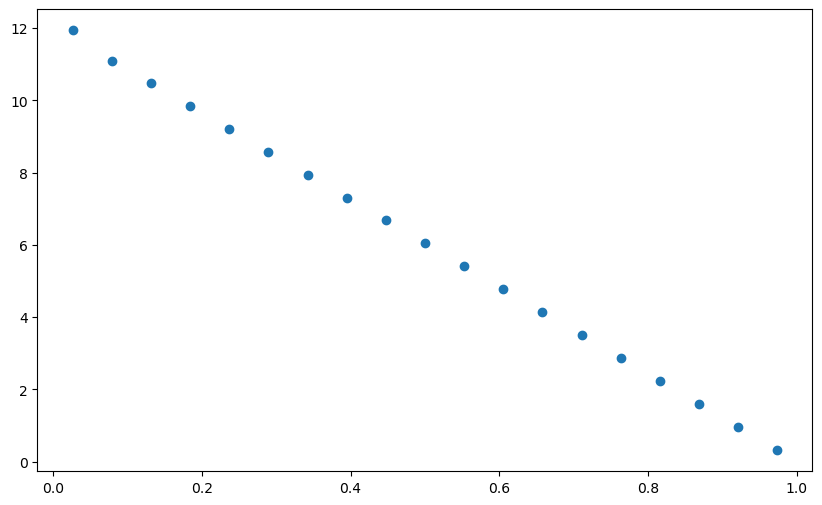

In [12]:
Vex = np.zeros(IDIM)
for i in range(0, NI+1):
   Vex[i] = 0.1*1.5*(1-XP[i]*XP[i]/XP[NI]/XP[NI])

i_range = range(1, NI)
j_range = range(1, NJ)

print(len(Vex[i_range]))
print(len(XP[i_range]))

plt.figure(figsize=(10,6))
# plt.plot(XP[i_range],Vex[i_range])
# plt.scatter(XP[i_range],V.PHI[i_range,19])
plt.scatter(YP[j_range],P.PHI[5,j_range])

In [14]:
#------------------------------CASE2------------------------------#

is_solve = {"P": True, "U": True, "V": True, "T": False}
is_debug = {"PHI": False, "RES": False}

config_domain(NX=20, NY=20, W=1, H=1)
init_domain()

RHS = np.zeros((IDIM, JDIM))
RES = np.zeros((IDIM, JDIM))

config_solver(jump=100, errmax=1e-5)
set_properties(RHO0=1000, MU0=0.001, CP0=1000, K0=1, QDOT0=0)

U = FieldEquation(
    name="U",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.7,
)

V = FieldEquation(
    name="V",
    BC=BoundaryValues(W=0, E=0.1, S=0, N=0),
    neumann={"N": "neumann"},
    relax=0.7,
)

P = FieldEquation(
    name="P",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={"S": "neumann", "W": "neumann", "E": "neumann"},
    relax=0.5,
)

U0 = 0
V0 = 0

U.PHI[:] = 0.0
V.PHI[:] = 0.0  
P.PHI[:] = 0.0

set_BC(U)
set_BC(V)
set_BC(P)
for i in range(0,NI+1): V[i][0]=0.1*XP[i]
for i in range(0,NI+1): V[i][1]=0.1*XP[i]

SOLVE_ALL(max_iter=2000,method="SIMPLEC",option="P",alpha=0)

iter=    0 U=  -1.008e-04 V=   7.536e-04 P=   3.142e-05 ResMax=   5.293e+29 Fcmax=   9.286e+29
iter=  100 U=   3.526e-04 V=   5.016e-02 P=   3.927e-03 ResMax=   2.378e-01 Fcmax=   3.547e-01
iter=  200 U=   2.518e-05 V=   5.001e-02 P=  -1.049e-02 ResMax=   6.391e-03 Fcmax=   1.261e-02
iter=  300 U=   6.379e-06 V=   5.000e-02 P=  -1.067e-02 ResMax=   3.754e-03 Fcmax=   8.653e-03
iter=  400 U=   1.424e-06 V=   5.000e-02 P=  -1.083e-02 ResMax=   3.870e-03 Fcmax=   9.056e-03
iter=  500 U=   3.165e-07 V=   5.000e-02 P=  -1.087e-02 ResMax=   3.874e-03 Fcmax=   9.068e-03
iter=  600 U=   7.028e-08 V=   5.000e-02 P=  -1.087e-02 ResMax=   3.874e-03 Fcmax=   9.070e-03
iter=  700 U=   1.560e-08 V=   5.000e-02 P=  -1.087e-02 ResMax=   3.874e-03 Fcmax=   9.070e-03
iter=  800 U=   3.464e-09 V=   5.000e-02 P=  -1.088e-02 ResMax=   3.874e-03 Fcmax=   9.070e-03
iter=  900 U=   7.690e-10 V=   5.000e-02 P=  -1.088e-02 ResMax=   3.874e-03 Fcmax=   9.070e-03
iter= 1000 U=   1.707e-10 V=   5.000e-02 P=  -1.08

19
19


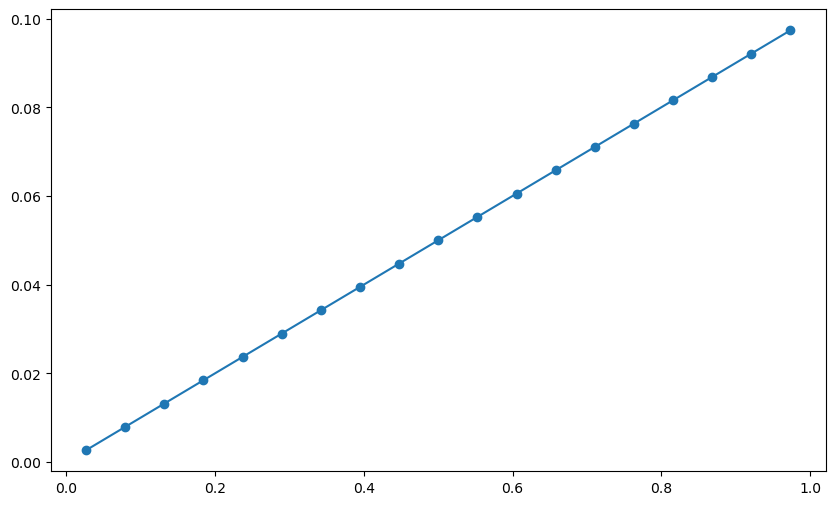

In [16]:
Vex = np.zeros(IDIM)
for i in range(0, NI+1):
   Vex[i] = 0.1*XP[i]

i_range = range(1, NI)
j_range = range(1, NJ)

print(len(Vex[i_range]))
print(len(XP[i_range]))

plt.figure(figsize=(10,6))
plt.plot(XP[i_range],Vex[i_range])
plt.scatter(XP[i_range],V.PHI[i_range,19])
# plt.scatter(YP[j_range],P.PHI[5,j_range])

In [32]:
#------------------------------CASE1------------------------------#
is_solve = {"P": True, "U": True, "V": True, "T": False}
is_debug = {"PHI": False, "RES": False}

config_domain(NX=20, NY=80, W=5e-3, H=1)
init_domain()

RHS = np.zeros((IDIM, JDIM))
RES = np.zeros((IDIM, JDIM))

config_solver(jump=50, errmax=1e-5)
set_properties(RHO0=100, MU0=0.001, CP0=1000, K0=1, QDOT0=0)

U = FieldEquation(
    name="U",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.6,
)

V = FieldEquation(
    name="V",
    BC=BoundaryValues(W=0, E=0, S=0.1, N=0),
    neumann={"N": "neumann", "W": "neumann"},
    relax=0.6,
)

P = FieldEquation(
    name="P",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={"S": "neumann", "W": "neumann", "E": "neumann"},
    relax=0.5,
)

U0 = 0
V0 = 0

U.PHI[:] = 0.0
V.PHI[:] = 0.0  
P.PHI[:] = 0.0

set_BC(U)
set_BC(V)
set_BC(P)

SOLVE_ALL(max_iter=1000,method="SIMPLE",option="PC",alpha=0)

iter=    0 U=   1.210e-17 V=   1.136e-12 P=   7.248e-10 ResMax=   3.987e+28 Fcmax=   1.179e+32
iter=   50 U=   7.454e-05 V=   1.087e-01 P=   4.184e+01 ResMax=   4.146e-02 Fcmax=   7.110e-02
iter=  100 U=  -4.633e-05 V=   1.912e-01 P=   1.402e+01 ResMax=   8.364e-03 Fcmax=   1.285e-01
iter=  150 U=  -6.888e-05 V=   1.250e-01 P=  -1.541e+01 ResMax=   9.244e-03 Fcmax=   7.760e-02
iter=  200 U=   2.636e-05 V=   6.363e-02 P=  -3.215e+00 ResMax=   8.015e-03 Fcmax=   1.654e-01
iter=  250 U=   4.961e-05 V=   9.214e-02 P=   1.727e+01 ResMax=   5.963e-03 Fcmax=   3.558e-02
iter=  300 U=  -9.872e-06 V=   1.358e-01 P=   1.480e+01 ResMax=   4.414e-03 Fcmax=   2.433e-02
iter=  350 U=  -3.215e-05 V=   1.303e-01 P=   9.511e-01 ResMax=   1.764e-03 Fcmax=   1.141e-01
iter=  400 U=  -5.375e-07 V=   1.001e-01 P=  -1.536e+00 ResMax=   3.783e-03 Fcmax=   1.320e-01
iter=  450 U=   1.980e-05 V=   9.460e-02 P=   7.347e+00 ResMax=   1.042e-03 Fcmax=   3.309e-02
iter=  500 U=   5.334e-06 V=   1.144e-01 P=   1.15

19
19


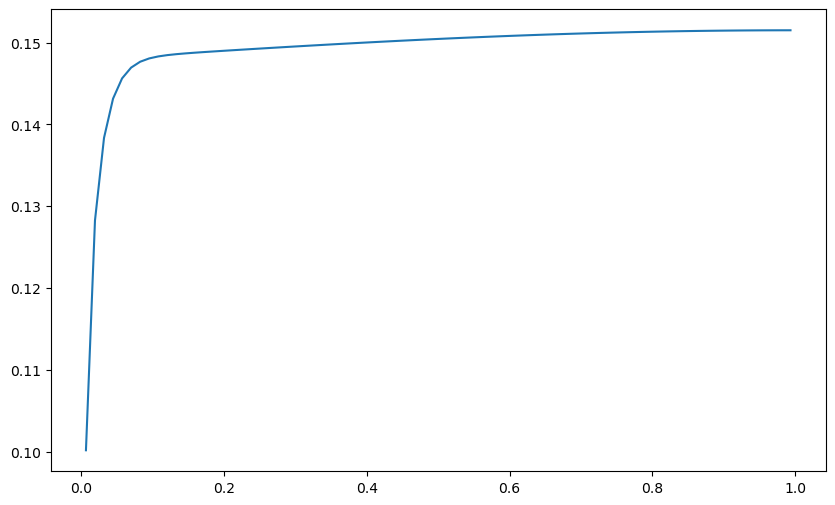

In [41]:
Vex = np.zeros(IDIM)
for i in range(0, NI+1):
   Vex[i] = 0.1*1.5*(1-XP[i]*XP[i]/XP[NI]/XP[NI])
Vref = 0.1*1.5*0.99

i_range = range(1, NI)
j_range = range(1, NJ)

print(len(Vex[i_range]))
print(len(XP[i_range]))

plt.figure(figsize=(10,6))
# plt.plot(XP[i_range],Vex[i_range])
# plt.scatter(XP[i_range],V.PHI[i_range,10])

# plt.plot(YP[j_range],Vref)
plt.plot(YP[j_range],V.PHI[0,j_range])

# plt.scatter(XP[i_range],V.PHI[i_range,15])
# plt.scatter(YP[j_range],P.PHI[8,j_range])
# plt.plot(YP[j_range],U.PHI[7,j_range])

In [ ]:
np.set_printoptions(
    threshold=np.inf,  
    precision=3,       
    suppress=True,     
    linewidth=200      
)
print("U:")
print(U.PHI[0:NI+1,0:NJ+1])
print("V:")
print(V.PHI[0:NI+1,0:NJ+1])
print("P")
print(P.PHI[0:NI+1,0:NJ+1])

# print("AP_V")
# print(AP_V[0:NI+1,0:NJ+1])
# print(DYV[0:NJ+1])


U:
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0

9
9


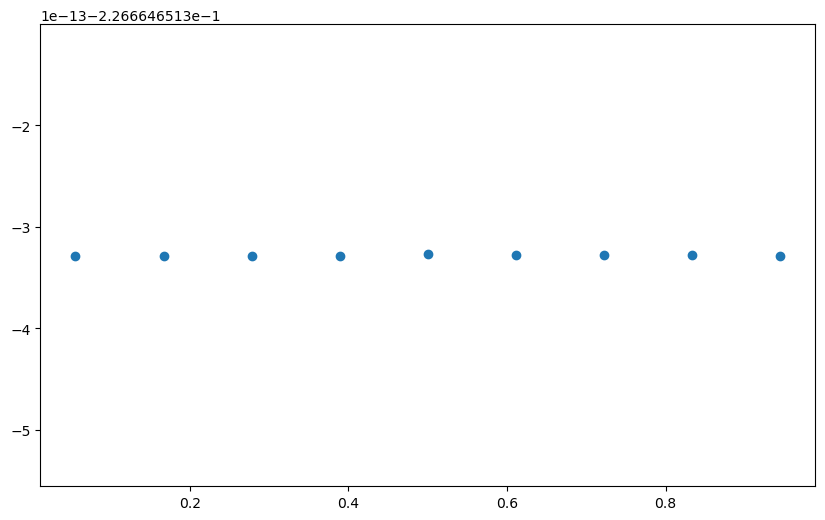

U:
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0. -0. -0. -0. -0.  0.  0.  0. -0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
V:
[[0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.          ]
 [0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556 0.0055555556]
 [0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667 0.0166666667]
 [0.0277777778 0.0277777778 0.02777777

In [ ]:
print(P.PHI.max())

0.0


In [ ]:
PREF=np.loadtxt("out_P")
PREF

array([[0.        , 9.441365  , 6.9770589 , 6.5860893 , 6.0060538 , 5.4895621 , 5.0359531 , 4.6100907 , 4.2072062 , 3.8225769 , 3.452298  , 3.093674  , 2.744632  , 2.4035346 , 2.0690738 ,
        1.7401785 , 1.4159872 , 1.0957256 , 0.77891729, 0.46464953, 0.15345114, 0.        ],
       [9.441365  , 9.441365  , 6.9770589 , 6.5860893 , 6.0060538 , 5.4895621 , 5.0359531 , 4.6100907 , 4.2072062 , 3.8225769 , 3.452298  , 3.093674  , 2.744632  , 2.4035346 , 2.0690738 ,
        1.7401785 , 1.4159872 , 1.0957256 , 0.77891729, 0.46464953, 0.15345114, 0.        ],
       [9.4419118 , 9.4419118 , 6.9765061 , 6.5859367 , 6.0059995 , 5.489534  , 5.0359331 , 4.6100766 , 4.2071958 , 3.8225689 , 3.4522917 , 3.0936691 , 2.7446281 , 2.4035314 , 2.0690712 ,
        1.7401764 , 1.4159855 , 1.0957242 , 0.77891606, 0.46464816, 0.1534433 , 0.        ],
       [9.4430439 , 9.4430439 , 6.9754559 , 6.5856964 , 6.0058903 , 5.4894837 , 5.0358983 , 4.610052  , 4.2071779 , 3.8225553 , 3.4522812 , 3.0936608 , 2.744